# Terrestrial Planets With Tides (500 Myr)

### Parameter Interpolation

If parameters are changing significantly on dynamical timescales (e.g. mass transfer at pericenter on very eccentric orbits) you need a specialized numerical scheme to do that accurately.
However, there are many astrophysical settings where parameters change very slowly compared to all the dynamical timescales in the problem.
As long as this is the case and the changes are adiabatic, you can modify these parameters between calls to `sim.integrate` very flexibly and without loss of accuracy. 

In order to provide a machine-independent way to interpolate parameters at arbitrary times, which can be shared between the C and Python versions of the code, we have implemented an interpolator object. 
For example, say you want to interpolate stellar evolution data.
We show below how you can use the `Interpolator` structure to spline a discrete set of time-parameter values.

We begin by reading in mass and radius data of our Sun, starting roughly 5 million years before the tip of its red-giant branch (RGB), and separating them into time and value arrays. 
You can populate these arrays however you want, but we load two text files (one for stellar mass, the other for stellar radius), where the first column gives the time (e.g., the Sun's age), and the second column gives the corresponding value (mass or radius).

All values need to be in simulation units. If you're using AU, then your stellar radii should also be in AU.

In [1]:
import numpy as np

data = np.loadtxt('mesa2txt/m.txt') # return (N, 2) array
mtimes = data[:, 0]                 # return only 1st col
masses = data[:, 1]                 # return only 2nd col

data = np.loadtxt('mesa2txt/r.txt')
rtimes = data[:, 0]
Rsuns = data[:, 1]                  # data in Rsun units

radii = np.zeros(Rsuns.size)        # convert Rsun to AU
for i, r in enumerate(Rsuns):
    radii[i] = r * 0.00465047       # 215 Rsun ~ 1 AU

### Tidal Parameters
The convective friction time is

\begin{equation}
t_f = \left(\dfrac{MR^2}{L}\right)^{1/3}.
\tag{1}
\end{equation}

We precaculate the values of $t_f(t)$ for the Sun's evolution, as all the parameters are already known in advance. Offloading this calculation before the simulation's start helps reduce extra math operations in between timesteps.

Our expression for Hut's constant time lag is

\begin{equation}
\tau = \dfrac{2R^3r}{GMt_f}.
\tag{2}
\end{equation}

Similarly, we can precalculate the known values of $\tau$ (all except for $r$) into its own "prefactor."

In [2]:
data = np.loadtxt('mesa2txt/l.txt')
ltimes = data[:, 0]
Lsuns = data[:, 1]                  # data in Lsun units

watts = np.zeros(Lsuns.size)        # convert Lsun to W (MKS units)
for i, l in enumerate(Lsuns):
    watts[i] = l * 3.828e26         # IAU Resolution B3 conversion

lumins = np.zeros(watts.size)       # convert W to sim units
for i, w in enumerate(watts):
    lumins[i] = (w * ((6.7e-12)**2) * (5e-31)) / ((3.2e-8)**3)

t_fs = np.zeros(lumins.size)        # precalculate t_f (Eq. 1)
for i, l in enumerate(lumins):
    t_fs[i] = np.cbrt(masses[i]*radii[i]**2/l)
    
pretaus = np.zeros(t_fs.size)       # precalc pretau (Eq. 2)
G = 4*np.pi**2                      # units of AU, yrs and solar masses
for i, t_f in enumerate(t_fs):
    pretaus[i] = 2.*radii[i]**3/G/masses[i]/t_f

Next we set up the Sun and all four terrestrial planets and load the `time_constant_time_lag` REBOUNDx force.

In [3]:
import rebound
import reboundx

M0 = 0.9900079494883252 # initial mass of star
names = ['Sun', 'Mercury', 'Venus', 'Earth', 'Mars']
symbols = ['☉', '☿', '♀︎', '⊕', '♂︎']

def tidesim():
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')
    sim.add(m=M0, hash=names[0])
    sim.add(m=0.166e-6, a=0.39, hash=names[1])
    sim.add(m=2.45e-6, a=0.723, hash=names[2])
    sim.add(m=3.e-6, a=1., hash=names[3])
    sim.add(m=0.323e-6, a=1.524, hash=names[4])
    sim.integrator = 'whfast'
    sim.dt = 0.1*sim.particles[1].P
    sim.move_to_com()
    rebx = reboundx.Extras(sim)
    tides = rebx.load_force("tides_constant_time_lag")
    rebx.add_force(tides)
    return sim, rebx, tides

Now we can create an `Interpolator` object for each parameter set and pass the corresponding arrays as arguments.

In [4]:
sim, rebx, tides = tidesim()
starmass = reboundx.Interpolator(rebx, mtimes, masses, 'spline')
starradius = reboundx.Interpolator(rebx, rtimes, radii, 'spline')
starptau = reboundx.Interpolator(rebx, ltimes, pretaus, 'spline')

# update Sun's mass and radius accordingly
ps = sim.particles
T0 = 12275.5e6 # Sun's age ~ 118 Myr pre-TRGB (sim start)
ps[0].m = starmass.interpolate(rebx, t=T0)
ps[0].r = starradius.interpolate(rebx, t=T0)
sim.move_to_com()

In [5]:
print(starmass.interpolate(rebx, t=T0))

0.9900079494883252


We specify the primary and secondaries' equilibrium gravitational response to the tidal field acting on them through the `tctl_k1` apsidal motion constant, equal to half the tidal Love number $k_2$. According to Zahn (1989), $\lambda_2 \approx k_1$.

If we give the primary a physical radius, then any (massive) orbiting body will raise equilibrium tides on the primary.

In [6]:
ps[0].params["tctl_k1"] = 0.038 # ~ lambda_2, Schroder & Smith (2008)

If we additionally set the `tctl_tau` constant time lag parameter, this delayed response introduces dissipation, which will typically cause eccentricity damping, and will migrate the orbiting bodies either inward or outward depending on whether they orbit faster or slower than the spin of the tidally deformed body. We set the spin rate of each body with the `Omega` parameter. If it is not set, `Omega` is assumed to be zero.

We note that this implementation assumes bodies' spins are fixed, so consider whether more angular momentum is being changed in the system than is available in the spins! We additionally assume that bodies spins are aligned with the reference z axis.

In [7]:
ps[0].params["tctl_tau"] = starptau.interpolate(rebx, t=T0)
ps[0].params["Omega"] = 0 # explicitly set to 0 (would be 0 by default)

Finally, we integrate for 5 Myr, updating the central body's mass and radius interpolated at the time between outputs. We then plot the resulting system:

In [8]:
%%time
Nout = 1000
mass = np.zeros(Nout)
radius = np.zeros(Nout)
a = np.zeros([Nout, sim.N])
ts = np.linspace(0., 118e6, Nout)
cp = 1                             # index of closest survivng planet
emass = 0.                         # mass of engulfed planets

for i, time in enumerate(ts):
    sim.integrate(time)
    d = ps[0] - ps[cp]             # componentwise difference to nearest planet
    r = np.sqrt(d.x**2 + d.y**2 + d.z**2)
    
    if r <= ps[0].r:               # nearest planet engulfed
        emass += ps[cp].m          # add engulfed planet mass
        ps[cp].m = 0               # zero planet mass and move to COM
        ps[cp].x, ps[cp].y, ps[cp].z = 0, 0, 0
        cp += 1                    # next closest surviving planet
        sim.dt = 0.1*ps[cp].P      # adjust timestep accordingly
        d = ps[0] - ps[cp]         # update distance to nearest survivor
        r = np.sqrt(d.x**2 + d.y**2 + d.z**2)
    
    # evolve Sun and recenter to COM
    ps[0].m = starmass.interpolate(rebx, t=T0+sim.t) + emass
    ps[0].r = starradius.interpolate(rebx, t=T0+sim.t)
    sim.move_to_com()
    
    # record values for post-sim plots
    mass[i] = sim.particles[0].m
    radius[i] = sim.particles[0].r
    for j in range(1, sim.N):
        a[i, j] = ps[j].a
    
    # update tidal parameter relative to nearest surviving planet
    ps[0].params["tctl_tau"] = starptau.interpolate(rebx, t=T0+sim.t)*r # Eq. 2

/home/stanley/miniconda3/envs/rebx/lib/python3.7/site-packages/rebound/simulation.py:675: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


CPU times: user 3h 40min 26s, sys: 1h 1min 44s, total: 4h 42min 10s
Wall time: 4h 43min 39s


In [9]:
def writetxt(times, values, path='data.txt'):
    """
    Function to output time-value series data to a two-column text file.
        
    Parameters
    ----------
    times : numpy.ndarray
        Monotonic array of times to be written out to the first
        column of the data file.
    values : numpy.ndarray
        Array of values (particular stellar property) to be written out to the
        second column of the data file.
    path : str
        Path and filename of the data file to be outputted.
        Default path set to working directory and filename "data.txt"
    """
    with open(path, 'w') as f: # will overwrite existing file
        for i in range(times.size):
            f.write('%.16E\t%.16E\n' % (times[i], values[i]))

In [10]:
writetxt(ts, mass, 'output/m_118Myr.txt')
writetxt(ts, radius, 'output/r_118Myr.txt')
for j in range(1, sim.N):
    fname = 'output/p' + str(j) + '_tides_118Myr.txt'
    writetxt(ts, a[:, j], path=fname)

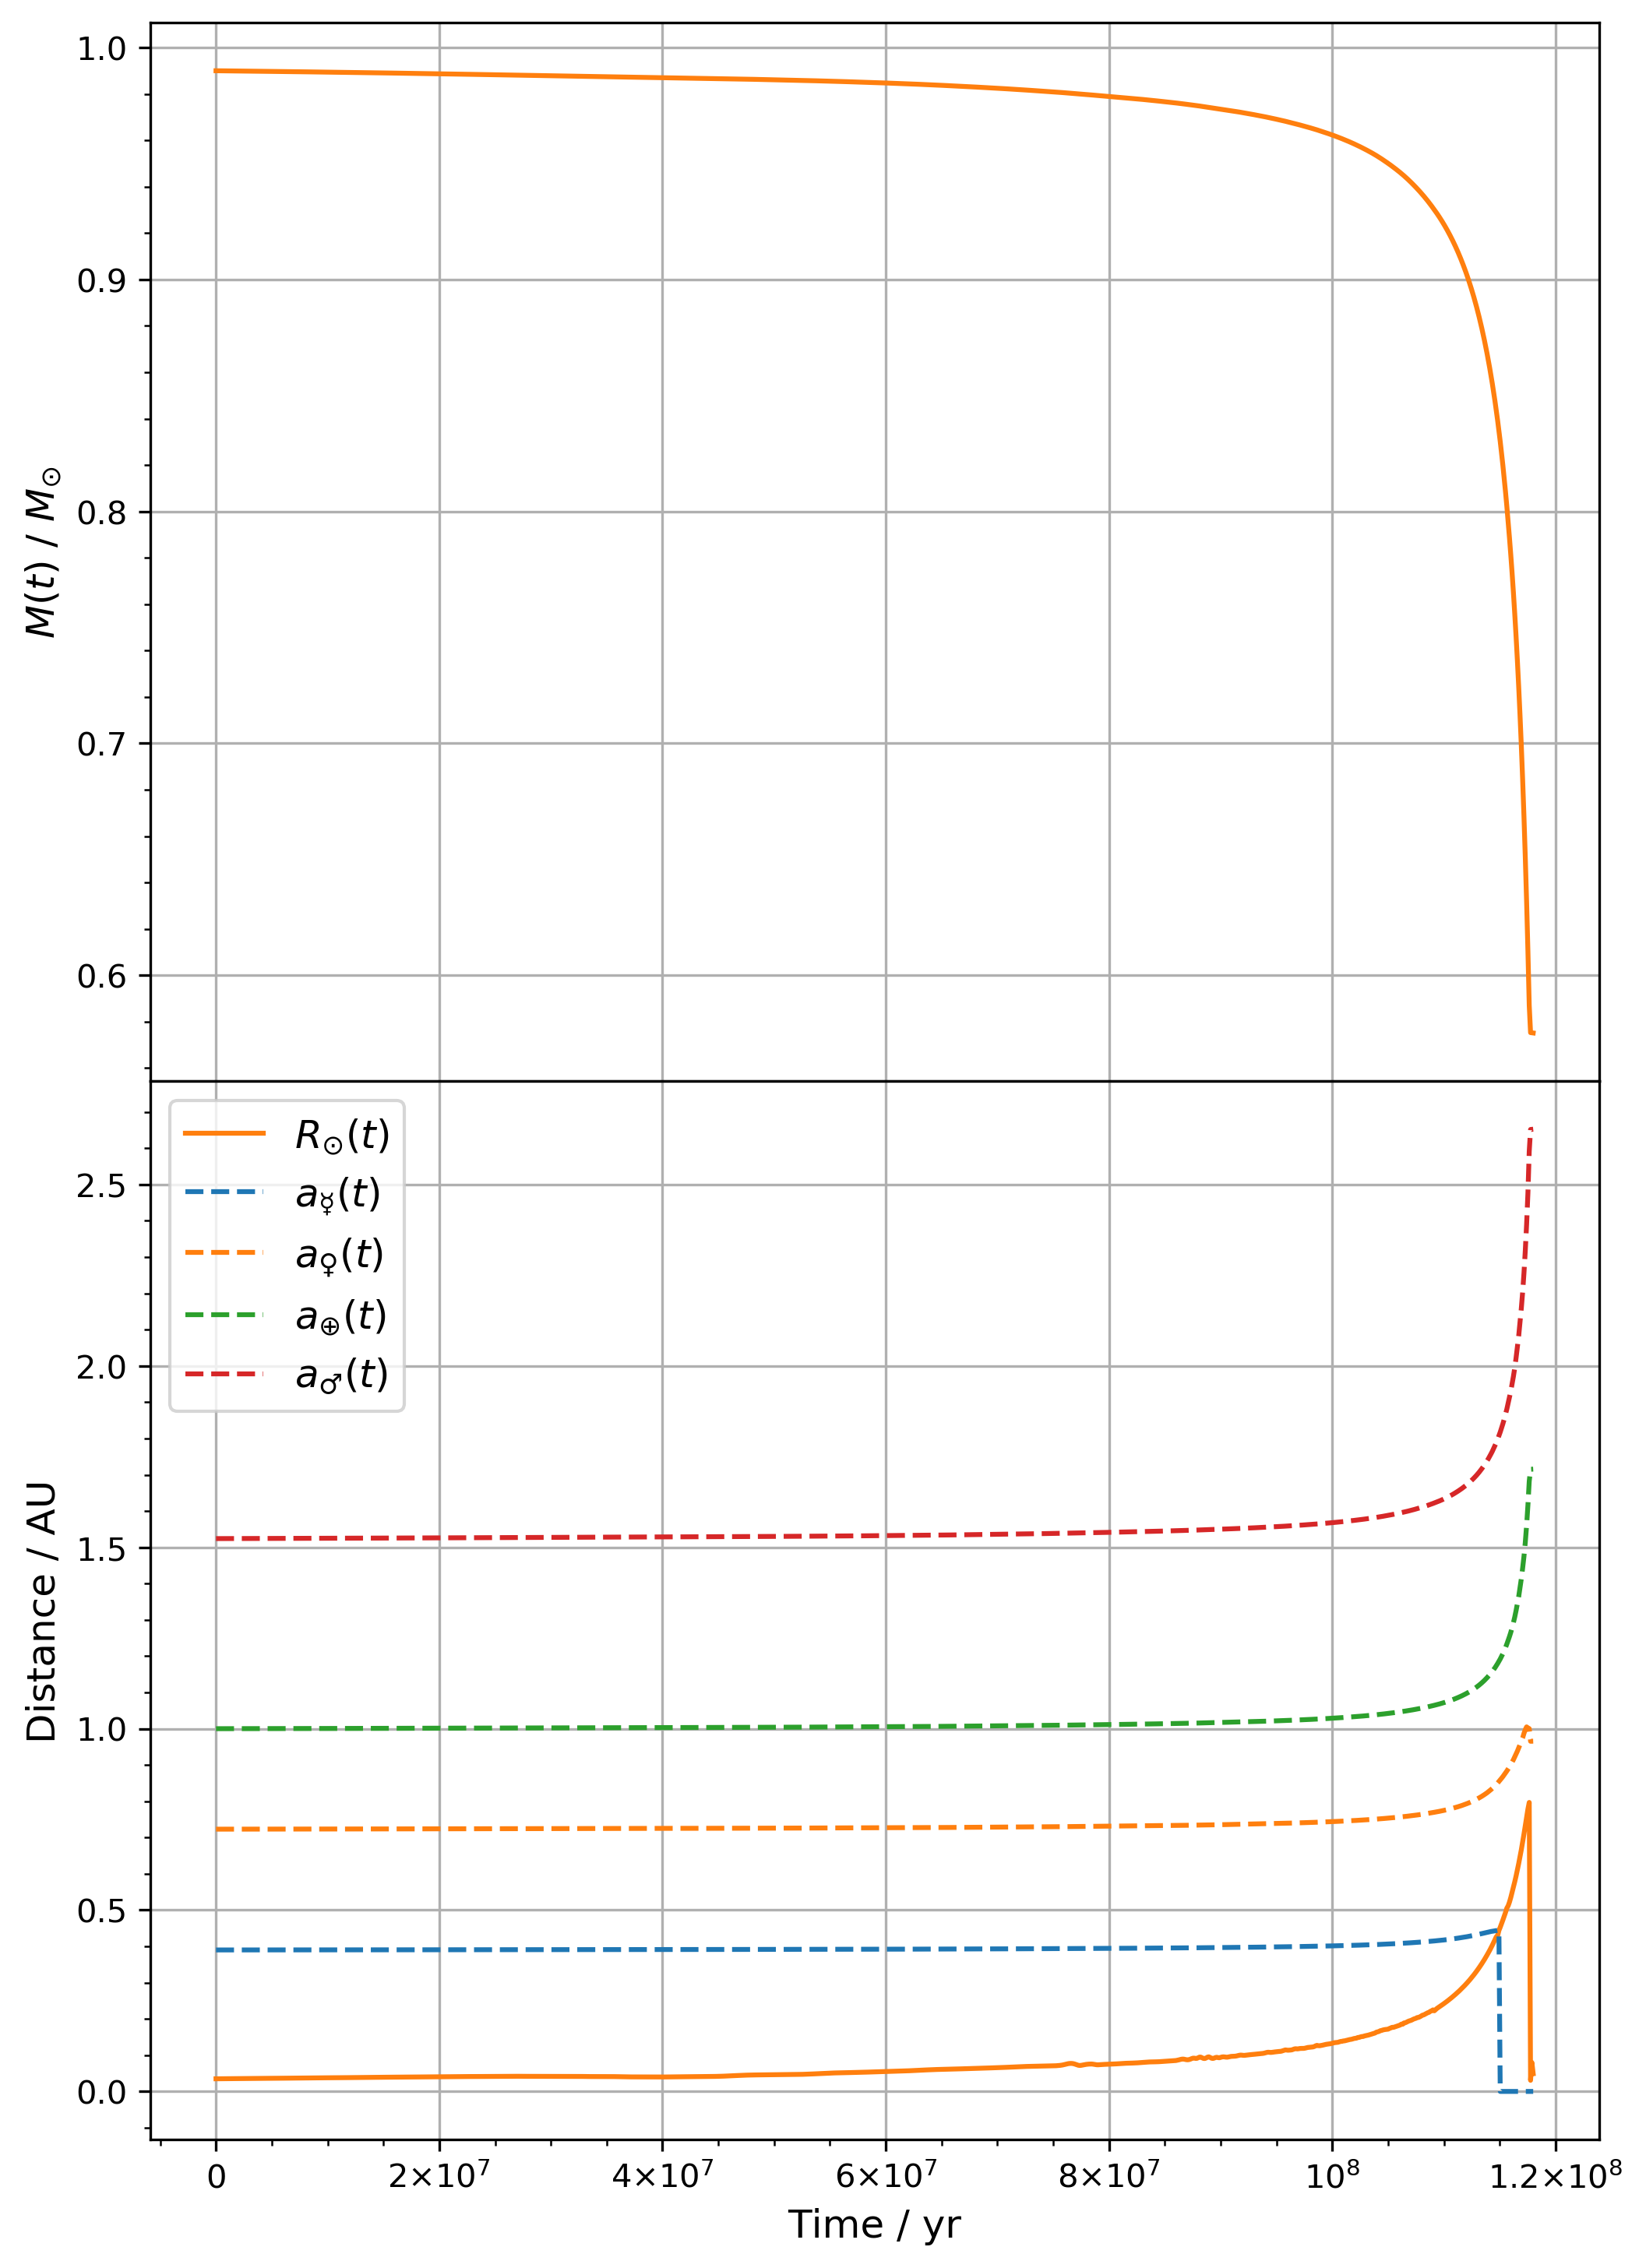

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 12), dpi=300)
fig.subplots_adjust(hspace=0)

ax1.set_ylabel("$M(t)$ / $M_{\odot}$", fontsize='large')
ax1.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.plot(ts,mass, color='tab:orange')
ax1.grid()

ax2.set_xlabel('Time / yr', fontsize='large')
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax2.xaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.set_ylabel('Distance / AU', fontsize='large')
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator())
ax2.plot(ts,radius, color='tab:orange', label='$R_{\odot}(t)$')
for i in range(1, sim.N):
    label = '$a_{%s}(t)$'%(symbols[i])
    ax2.plot(ts,a[:, i], '--', label=label)
ax2.legend(fontsize='large', loc='best')
ax2.grid()

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.savefig('plots/terrestrial_tides_118Myr.png')